# Lecture 4
### Peru (BCRPData API)
- **FX**: Interbank USD/PEN (buy) vs SBS banking system USD/PEN (buy)
- **Commodities**: Gold and Copper reference prices (daily series published by BCRP)

### USA (Yahoo Finance via `yfinance`)
- **Market**: SPY (US equities), TLT (US long bonds), GLD (gold ETF)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

pd.set_option("display.max_columns", 120)

In [3]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

# Configuration


CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Cache utilities (parquet -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

## 0) Load real financial data

If an endpoint is temporarily unavailable, this notebook prints a short message and continues

In [4]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()


Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


In [5]:
peru_wide.head()

,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


In [6]:
usa

Price,date,ticker,close,volume,ret
0,2022-01-03,GLD,168.330002,9014400,NaN
1,2022-01-04,GLD,169.570007,6965600,0.007367
2,2022-01-05,GLD,169.059998,8715600,-0.003008
3,2022-01-06,GLD,166.990005,10902700,-0.012244
4,2022-01-07,GLD,167.750000,8191900,0.004551
...,...,...,...,...,...
2977,2025-12-11,TLT,88.190002,26778700,-0.001359
2978,2025-12-12,TLT,87.339996,47030100,-0.009638
2979,2025-12-15,TLT,87.400002,28611800,0.000687
2980,2025-12-16,TLT,87.879997,41018700,0.005492


## 1) Quantities

### Exercise 1.1 — FX level comparison (Peru)

**Tasks**
1. Filter `peru` to the two FX series (Interbank buy and SBS buy).
2. Pivot to wide format (`date` as index).
3. Plot both FX levels in the same line chart.
4. Create `spread = sbs - interbank` and plot it in a separate figure.

In [7]:
# Excercise 1.1: Filter peru to the two FX series (Interbank buy and SBS buy).
peru_filt = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD"],
    start=START_D,
    end=END_D,
    lang="ing"
)
print(peru_filt)

           date                                        series_name     value
0    2022-01-03  Tipo de cambio - TC Interbancario (S/ por US$)...  3.983667
1    2022-01-04  Tipo de cambio - TC Interbancario (S/ por US$)...  3.959500
2    2022-01-05  Tipo de cambio - TC Interbancario (S/ por US$)...  3.952000
3    2022-01-06  Tipo de cambio - TC Interbancario (S/ por US$)...  3.967167
4    2022-01-07  Tipo de cambio - TC Interbancario (S/ por US$)...  3.945167
...         ...                                                ...       ...
1971 2025-12-12  Tipo de cambio - TC Sistema bancario SBS (S/ p...  3.363000
1972 2025-12-15  Tipo de cambio - TC Sistema bancario SBS (S/ p...  3.365000
1973 2025-12-16  Tipo de cambio - TC Sistema bancario SBS (S/ p...  3.366000
1974 2025-12-17  Tipo de cambio - TC Sistema bancario SBS (S/ p...  3.365000
1975 2025-12-18  Tipo de cambio - TC Sistema bancario SBS (S/ p...  3.363000

[1976 rows x 3 columns]


In [8]:
# # Excercise 1.2: Pivot to wide format (date as index).


peru_wide.columns.name = None ### We removed the name in order to apply names in a uniform format

rename_map = {} ### List of names that we will apply
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"

peru_wide2 = peru_wide.rename(columns=rename_map)
peru_wide2.head()

,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


In [9]:
peru_wide.head()### Wide format

,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


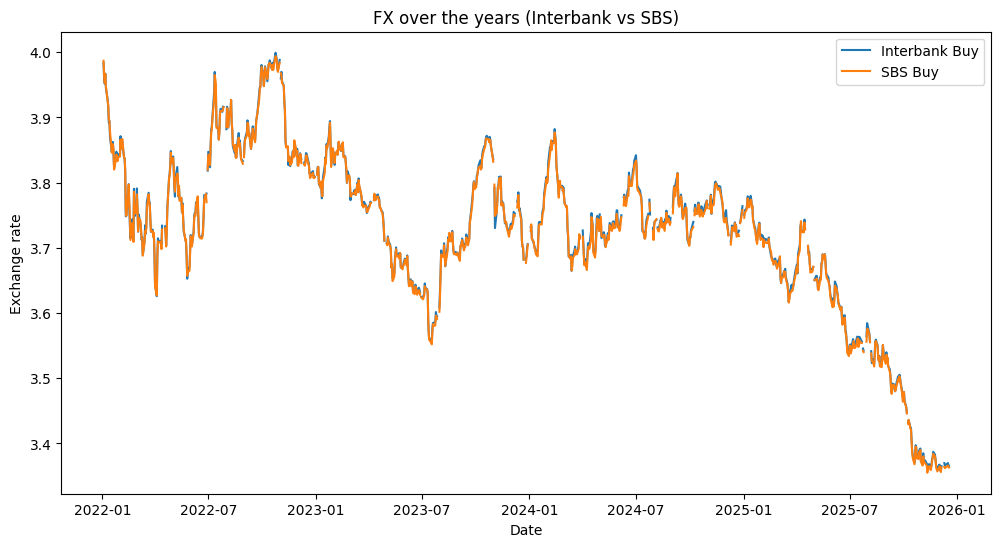

The values should be very similar, since the SBS exchange rate is published as the official reference, based on the average of exchange rate transactions. If they were to differ significantly, there could be an opportunity to arbitrage those differences.


In [10]:
# Excercise 1.3: Plot both FX levels in the same line chart.
plt.figure(figsize=(12, 6))
plt.plot(peru_wide2['date'], peru_wide2['fx_interbank_buy'], label='Interbank Buy')
plt.plot(peru_wide2['date'], peru_wide2['fx_sbs_buy'], label='SBS Buy')
plt.title('FX over the years (Interbank vs SBS)')
plt.xlabel('Date')
plt.ylabel('Exchange rate')
plt.legend()
plt.show()
print('The values should be very similar, since the SBS exchange rate is published as the official reference, based on the average of exchange rate transactions. If they were to differ significantly, there could be an opportunity to arbitrage those differences.')

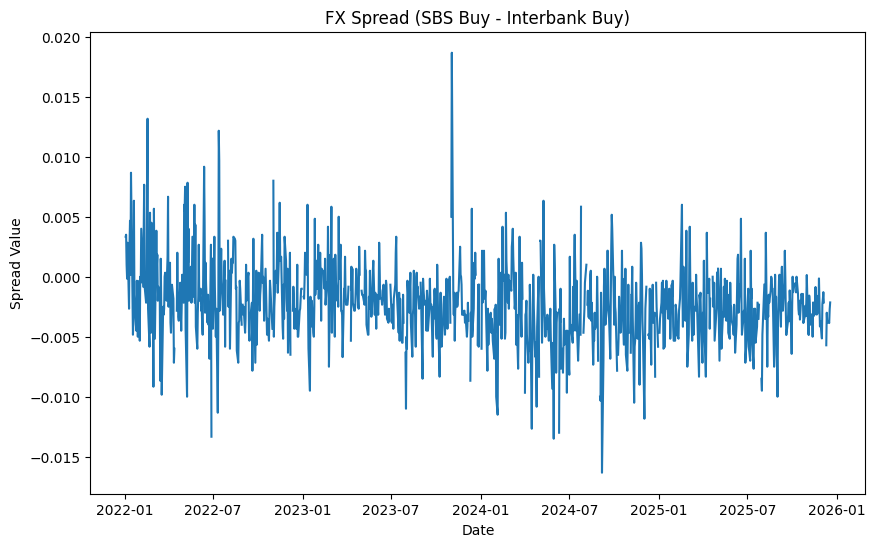

In [11]:
# Excercise 1.4: Create spread = sbs - interbank and plot it in a separate figure.
spread = peru_wide2['fx_sbs_buy'] - peru_wide2['fx_interbank_buy']

plt.figure(figsize=(10, 6))
plt.plot(peru_wide2['date'], spread)
plt.title('FX Spread (SBS Buy - Interbank Buy)')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.show()

Comment: It is observed that the spread between the SBS and Interbank exchange rates exhibits behavior with mean = 0 and certain volatility (similar to a zero-mean Random Walk). There have been historical scenarios that generated high volatility in the spread.

## 2) Proportions

### Exercise 2.1 — Share of positive-return days (USA)

Define a positive day as `ret > 0`.

**Tasks**
1. For each ticker in `usa`, compute the share of days with `ret > 0`.
2. Plot a bar chart of these shares.
3. Add labels (percent format) and a title.

In [12]:
### 1. For each ticker in usa, compute the share of days with ret > 0.
usa.isnull().sum() ### We identified that there are 3 null values due to the returns, which is common when calculating returns
usa = usa.dropna(subset=['ret']) ### We removed those three NaN values
usa.isnull().sum() ### There are no longer any NaN values

posit_ret_share = usa.groupby('ticker')['ret'].apply(lambda x: (x > 0).mean()) ### Calculate the share of positive returns,
#First, convert it into a DataFrame of booleans (1s and 0s) indicating whether the value is positive. Then, apply the median to those 1s, since with values of 1s and 0s, the median represents the percentage of the total days
print(posit_ret_share)

ticker
GLD    0.545821
SPY    0.535750
TLT    0.493454
Name: ret, dtype: float64


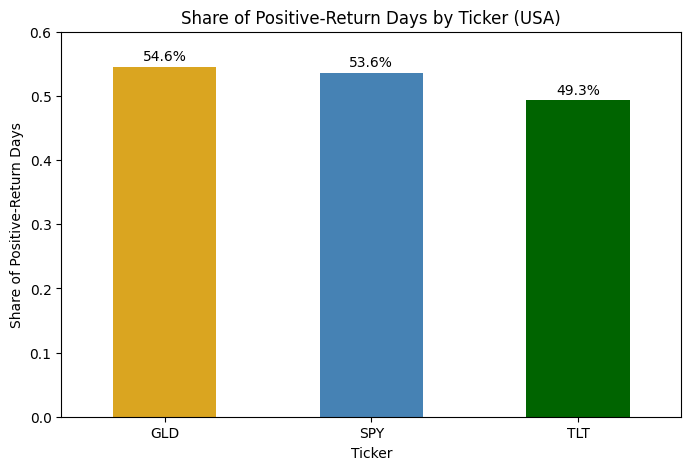

In [13]:
### Exercise 2.1.2: Plot a bar chart of these shares, add labels and a title.
plt.figure(figsize=(8, 5))
colors = ['goldenrod','steelblue' ,'darkgreen'] # Define colors for each ticker
posit_ret_share.plot(kind='bar', color=colors)
plt.title('Share of Positive-Return Days by Ticker (USA)')
plt.xlabel('Ticker')
plt.ylabel('Share of Positive-Return Days')

#Add labels (percent format) and a title.
for index, value in enumerate(posit_ret_share):
    plt.text(index, value + 0.01, f'{value:.1%}', ha='center') # Format as percentage



plt.ylim(0, posit_ret_share.max() * 1.1) # Adjust y-limit to make space for labels
plt.xticks(rotation=0)
plt.show()

## 3) Distributions

### Exercise 3.1 — Return distributions: Peru Gold vs US Gold ETF

**Goal:** compare distributions of a **Peru gold reference price** series vs the **US gold ETF (GLD)**.

**Tasks**
1. From `peru`, build a daily gold series and compute returns.
2. From `usa`, filter to GLD returns.
3. Plot two histograms (separate figures) with the same binning.
4. Optional: overlay KDE for each distribution.

In [14]:
peru_wide.head()

,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


In [15]:
# Exercise 3.1.1: From peru, build a daily gold series and compute returns
peru_gold = peru_wide['gold_london']
peru_gold_ret = pct_change(peru_gold)

peru_gold_ret_df = pd.DataFrame({
    'date': peru_wide['date'],
    'gold_returns': peru_gold_ret
})

peru_gold_ret_df = peru_gold_ret_df.dropna(subset=['gold_returns']).reset_index(drop=True)

display(peru_gold_ret_df.head())

,date,gold_returns
0,2022-01-04,-0.004780
1,2022-01-05,0.008198
2,2022-01-06,-0.020205
3,2022-01-07,0.001816
4,2022-01-10,0.000893


In [16]:
# Exercise 3.1.1: From usa, filter to GLD returns.

usa_gld_ret = usa[usa['ticker'] == 'GLD'][['date', 'ret']].copy() ### I filter by the GLD ticker and then keep the date and ret columns

usa_gld_ret = usa_gld_ret.rename(columns={'ret': 'GLD_returns'}) ### I renamed the ret column to GLD_returns for better identification

usa_gld_ret = usa_gld_ret.dropna(subset=['GLD_returns']).reset_index(drop=True) ### I remove the NaN values

display(usa_gld_ret.head())

Price,date,GLD_returns
0,2022-01-04,0.007367
1,2022-01-05,-0.003008
2,2022-01-06,-0.012244
3,2022-01-07,0.004551
4,2022-01-10,0.003040


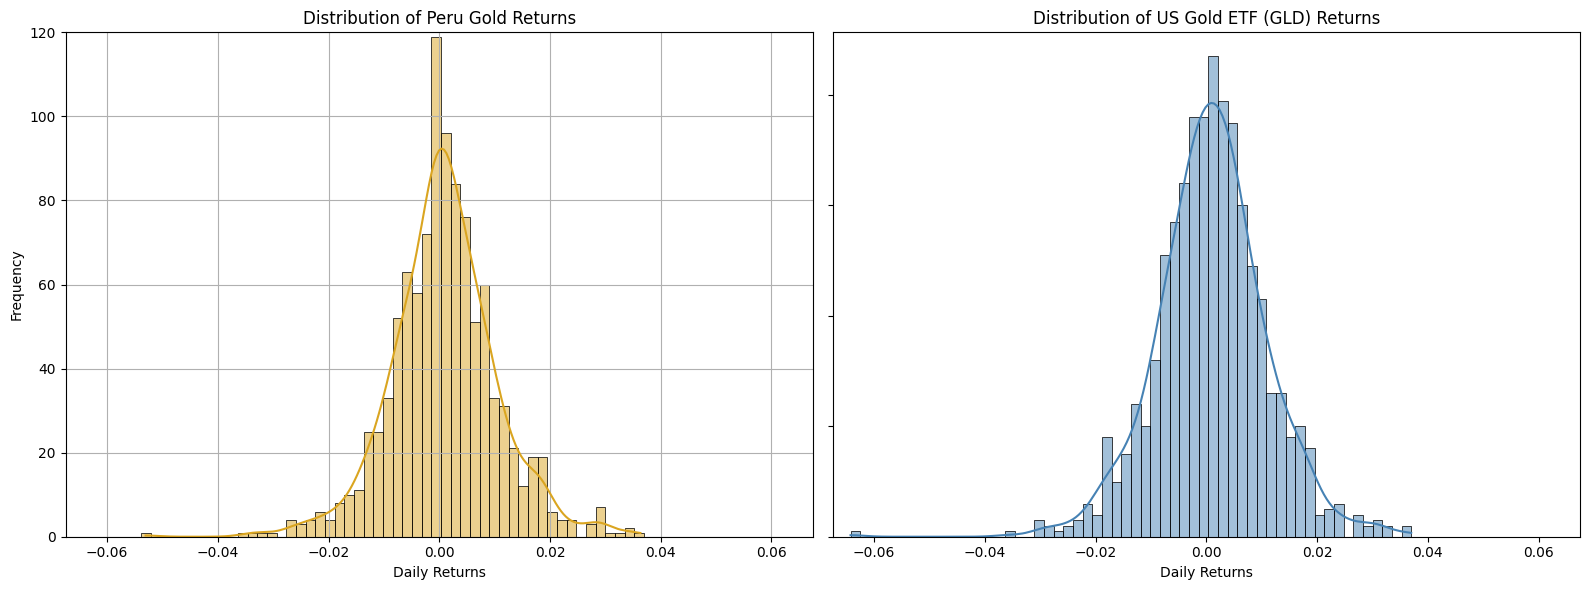

In [17]:
# Excercise 3.1.3: Plot two histograms (separate figures) with the same binning.

# 1. Combine the gold_returns from peru and usa
combined_returns = pd.concat([
    peru_gold_ret_df['gold_returns'],
    usa_gld_ret['GLD_returns']
]).dropna()

# 2. Calculating returns data
bins = np.histogram_bin_edges(combined_returns, bins='auto')

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)

max_abs_return = np.max(np.abs(combined_returns))
xlim_val = max_abs_return * 1.05
axes[0].set_xlim(-xlim_val, xlim_val)

# 3. Creating the first histogram for peru
sns.histplot(peru_gold_ret_df['gold_returns'], bins=bins, kde=True, ax=axes[0], color='goldenrod', stat='count') # stat='count'
axes[0].set_title('Distribution of Peru Gold Returns')

axes[0].set_xlabel('Daily Returns')
axes[0].set_ylabel('Frequency')
axes[0].set_ylim(0, 120)
axes[0].grid(True)

# 6. Creating the second histogram for usa
sns.histplot(usa_gld_ret['GLD_returns'], bins=bins, kde=True, ax=axes[1], color='steelblue', stat='count') # stat='count'

axes[1].set_title('Distribution of US Gold ETF (GLD) Returns')

# 8. Label the x-axis as 'Daily Returns' and the y-axis as 'Frequency / Count'
axes[1].set_xlabel('Daily Returns')
axes[1].set_ylabel('')

axes[1].tick_params(axis='y', labelleft=False)

plt.tight_layout()
plt.show()

## 4) Relationships

### Exercise 4.1 — FX changes vs market returns (Peru + USA)

Use:
- Peru interbank FX (daily % change)
- SPY returns (broad US market benchmark)

**Tasks**
1. Build interbank FX daily returns from the Peru FX series.
2. Build SPY daily returns from `usa`.
3. Merge on date.
4. Scatter plot (x = SPY ret, y = FX ret).
5. Compute correlation and write 2–3 sentences interpreting the sign/magnitude.

In [18]:
peru_wide.head()

,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


In [19]:
usa

Price,date,ticker,close,volume,ret
1,2022-01-04,GLD,169.570007,6965600,0.007367
2,2022-01-05,GLD,169.059998,8715600,-0.003008
3,2022-01-06,GLD,166.990005,10902700,-0.012244
4,2022-01-07,GLD,167.750000,8191900,0.004551
5,2022-01-10,GLD,168.259995,7026500,0.003040
...,...,...,...,...,...
2977,2025-12-11,TLT,88.190002,26778700,-0.001359
2978,2025-12-12,TLT,87.339996,47030100,-0.009638
2979,2025-12-15,TLT,87.400002,28611800,0.000687
2980,2025-12-16,TLT,87.879997,41018700,0.005492


In [20]:
###Exercise 4.1 — FX changes vs market returns (Peru + USA)
### 1. Build interbank FX daily returns from the Peru FX series.
peru_wide = peru_wide.set_index('date')
peru_fx_ret = pct_change(peru_wide['fx_interbank_buy'])

peru_fx_ret = peru_fx_ret.rename('fx_interbank_buy_ret')
peru_fx_ret = peru_fx_ret.dropna().reset_index()

print(peru_fx_ret)

### 2. Build SPY daily retunrs from usa
usa_spy_ret = usa[usa['ticker'] == 'SPY'][['date', 'ret']].copy()
usa_spy_ret = usa_spy_ret.rename(columns={'ret': 'SPY_returns'})
usa_spy_ret = usa_spy_ret.dropna(subset=['SPY_returns']).reset_index(drop=True)
print(usa_spy_ret)


          date  fx_interbank_buy_ret
0   2022-01-04             -0.006066
1   2022-01-05             -0.001894
2   2022-01-06              0.003838
3   2022-01-07             -0.005546
4   2022-01-10             -0.004436
..         ...                   ...
947 2025-12-12              0.000552
948 2025-12-15              0.000552
949 2025-12-16              0.000339
950 2025-12-17             -0.000636
951 2025-12-18             -0.000764

[952 rows x 2 columns]
Price       date  SPY_returns
0     2022-01-04    -0.000335
1     2022-01-05    -0.019202
2     2022-01-06    -0.000939
3     2022-01-07    -0.003954
4     2022-01-10    -0.001244
..           ...          ...
988   2025-12-11     0.002327
989   2025-12-12    -0.010752
990   2025-12-15    -0.001511
991   2025-12-16    -0.002732
992   2025-12-17    -0.011004

[993 rows x 2 columns]


In [21]:
### 3 Merge on date
merged_df = pd.merge(peru_fx_ret, usa_spy_ret, on='date', how='inner') ### We apply the merge to the date, with 'inner', meaning it will only take the values ​​that have the same index.
print(merged_df)

          date  fx_interbank_buy_ret  SPY_returns
0   2022-01-04             -0.006066    -0.000335
1   2022-01-05             -0.001894    -0.019202
2   2022-01-06              0.003838    -0.000939
3   2022-01-07             -0.005546    -0.003954
4   2022-01-10             -0.004436    -0.001244
..         ...                   ...          ...
917 2025-12-11             -0.001399     0.002327
918 2025-12-12              0.000552    -0.010752
919 2025-12-15              0.000552    -0.001511
920 2025-12-16              0.000339    -0.002732
921 2025-12-17             -0.000636    -0.011004

[922 rows x 3 columns]


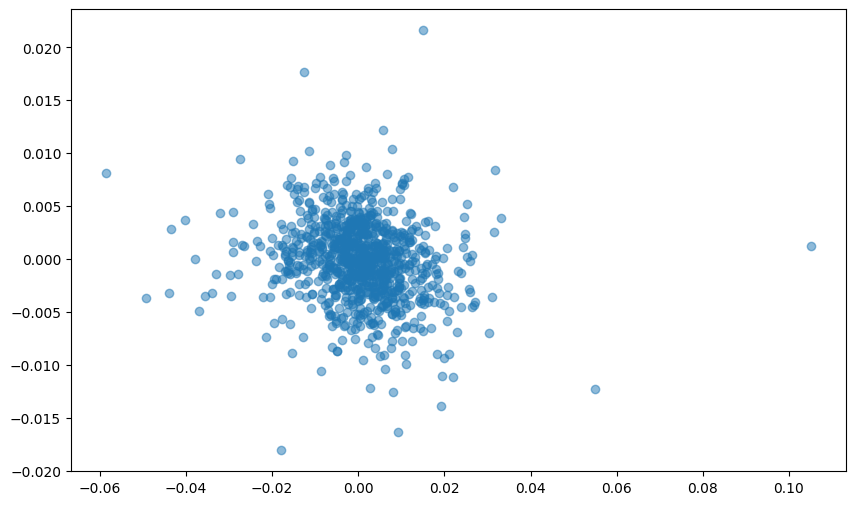

In [22]:
### 4 Scatter plot (x = SPY ret, y = FX ret).
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['SPY_returns'], merged_df['fx_interbank_buy_ret'], alpha=0.5) ### Scatter



In [23]:
# Compute correlation and write 2–3 sentences interpreting the sign/magnitude.
correlation_matrix = merged_df[['SPY_returns', 'fx_interbank_buy_ret']].corr()
print(correlation_matrix)

                      SPY_returns  fx_interbank_buy_ret
SPY_returns              1.000000             -0.178136
fx_interbank_buy_ret    -0.178136              1.000000


Comentario: El coef. de correlación resultó negativa, eso quiere decir que existe un comovimiento inverso entre los retornos de SPY y el tipo de cambio FX USD/PEN. Se podría pensar que ante movimientos positivos del SPY, en el mercado de FX USD/PEN hay una caída del tipo de cambio. Importante denotar que  la correlación no implica causalidad si no una muestra del comportamiento, tal vez otros  factores expliquen mejor su comportamiento

## 5) References

- BCRP Statistical Series (Daily): exchange rates and commodities series catalog.
- BCRPData API (CSV endpoint) for downloading series.
- yfinance: Python wrapper that fetches historical market data from Yahoo Finance.

## 2) Online Data Sources

### Exercise 2.1 — Inspect the BCRPData API URL (requests)
You are already downloading from BCRPData. Now you will **inspect** what is being requested.

**Tasks**
1. Recreate the API URL string used to download the Peru series.
2. Print it.
3. Download the CSV text using `http_get_text` and display the first 10 lines.
4. Explain (in a markdown cell) what each part of the URL means.

In [24]:
### 1. Recreate the API URL string used to download the Peru series.

codes = "-".join(["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]) ### The codes of the assets I want to download from the BCRP data source
start = "2022-01-01" ### To modify the download start date
end = "2025-12-18" ### To modify the download end date
lang = "ing" ### To modify the download language

url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}" ### This is the resulting URL
### 2. Print it.
print(url)

###3. Download the CSV text using http_get_text and display the first 10 lines.
txt = http_get_text(url, timeout=30) ### This code provides the database as a large String to check encoding, separators, and more

lines = txt.splitlines()

for line in lines[:10]: ### To show only the first 10 lines of the downloaded database
    print(line)

https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/csv/2022-01-01/2025-12-18/ing
D&iacute;a/Mes/A&ntilde;o,"Tipo de cambio - TC Interbancario (S/ por US$) - Compra","Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra","Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)","Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)"<br>"03.Jan.22","3.98366666666667","3.987","439.621724973844","1820.1"<br>"04.Jan.22","3.9595","3.963","438.170229389944","1811.4"<br>"05.Jan.22","3.952","3.953","443.522619355577","1826.25"<br>"06.Jan.22","3.96716666666667","3.967","433.86110187524","1789.35"<br>"07.Jan.22","3.94516666666667","3.948","436.129063725084","1792.6"<br>"10.Jan.22","3.92766666666667","3.925","438.397025574929","1794.2"<br>"11.Jan.22","3.91633333333333","3.919","438.260947863938","1806.8"<br>"12.Jan.22","3.89233333333333","3.897","451.097611934057","1821.4"<br>"13.Jan.22","3.89483333333333","3.895","452.3223

### Explanation of the BCRPData API URL

Example URL:

https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/csv/2022-01-01/2025-12-18/ing

**Explanation of each component:**

- **https://estadisticas.bcrp.gob.pe**  
  Base domain of the Central Reserve Bank of Peru (BCRP) statistics portal.  
  This domain hosts official macroeconomic and financial time series published by the BCRP.

- **/estadisticas/series/api/**  
  Fixed API path used to query time series data programmatically.  
  It indicates that the request is made through the BCRP series API rather than via the web interface.

- **PD04637PD-PD04639PD-PD04704XD-PD04701XD**  
  List of BCRP series codes requested.  
  Each code uniquely identifies a specific economic time series.  
  Multiple series can be requested simultaneously by separating their codes with hyphens (`-`).

- **/csv**  
  Specifies the output format of the response.  
  In this case, the API returns the data in CSV (Comma-Separated Values) format.

- **/2022-01-01/2025-12-18**  
  Start and end dates of the requested time range.  
  These parameters restrict the returned observations to the specified period.

- **/ing**  
  Language parameter of the response.  
  `ing` indicates English output, affecting column names and labels in the returned data.


In [25]:
from pathlib import Path
import time
import requests

def fetch_text_with_session(url: str, timeout: int = 30, tries: int = 3) -> str:
    """Fetch raw text using a requests.Session (cookies) + browser-like headers."""
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.9,es;q=0.8",
        "Referer": "https://estadisticas.bcrp.gob.pe/",
        "Connection": "keep-alive",
        "Cache-Control": "no-cache",
        "Pragma": "no-cache",
    }

    s = requests.Session()

    # Warm-up request to get cookies (can help with WAF/403)
    try:
        s.get("https://estadisticas.bcrp.gob.pe/", headers=headers, timeout=timeout)
    except Exception:
        pass

    last = None
    for k in range(tries):
        try:
            r = s.get(url, headers=headers, timeout=timeout)
            if r.status_code == 403:
                last = requests.HTTPError(f"403 Forbidden for url: {url}")
                time.sleep(1.5 * (k + 1))
                continue
            r.raise_for_status()
            return r.text
        except Exception as e:
            last = e
            time.sleep(1.5 * (k + 1))

    raise last


SERIES = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

START_D = "2022-01-01"
END_D   = "2025-12-18"
LANG    = "ing"

# 1) Recreate the API URL string used to download the Peru series
codes = "-".join(SERIES)
url_multi = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{START_D}/{END_D}/{LANG}"

print("BCRPData URL (multi-series):")
print(url_multi)

# 2-3) Try to download raw CSV text and show first 10 lines
txt = None
raw_source = None

try:
    txt = fetch_text_with_session(url_multi, timeout=30, tries=3)
    raw_source = "server (multi-series)"
except Exception as e:
    print(f"[BCRP] Multi-series request failed: {type(e).__name__}: {e}")

# Fallback: try only ONE series (often allowed even if multi is blocked)
if txt is None:
    one = SERIES[0]
    url_one = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{one}/csv/{START_D}/{END_D}/{LANG}"
    print("\nBCRPData URL (single-series fallback):")
    print(url_one)
    try:
        txt = fetch_text_with_session(url_one, timeout=30, tries=3)
        raw_source = f"server (single-series: {one})"
    except Exception as e:
        print(f"[BCRP] Single-series request failed: {type(e).__name__}: {e}")

if txt is not None:
    # Replace <br> HTML tags with newline characters (some responses use HTML breaks)
    txt_clean = (txt.replace("<br />", "\n").replace("<br/>", "\n").replace("<br>", "\n"))

    lines = txt_clean.splitlines()
    print(f"\nFirst 10 lines of the response ({raw_source}):")
    for i, line in enumerate(lines[:10], start=1):
        print(f"{i:02d}: {line}")

else:
    # Last-resort fallback: reconstruct "CSV-like" lines from your cached dataframes
    # NOTE: this is NOT the raw server response; it's reconstructed from local data.
    print("\n[BCRP] Could not fetch raw text due to 403. Reconstructing lines from local data (NOT raw server response).")

    # Try to use peru_w if it exists; else use peru if it exists.
    if "peru_w" in globals() and hasattr(peru_w, "head"):
        preview = peru_w.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru_w):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    elif "peru" in globals() and hasattr(peru, "head"):
        preview = peru.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    else:
        print("No local dataframes found (peru/peru_w). Run the download cells first.")


BCRPData URL (multi-series):
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/csv/2022-01-01/2025-12-18/ing

First 10 lines of the response (server (multi-series)):
01: D&iacute;a/Mes/A&ntilde;o,"Tipo de cambio - TC Interbancario (S/ por US$) - Compra","Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra","Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)","Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)"
02: "03.Jan.22","3.98366666666667","3.987","439.621724973844","1820.1"
03: "04.Jan.22","3.9595","3.963","438.170229389944","1811.4"
04: "05.Jan.22","3.952","3.953","443.522619355577","1826.25"
05: "06.Jan.22","3.96716666666667","3.967","433.86110187524","1789.35"
06: "07.Jan.22","3.94516666666667","3.948","436.129063725084","1792.6"
07: "10.Jan.22","3.92766666666667","3.925","438.397025574929","1794.2"
08: "11.Jan.22","3.91633333333333","3.919","438.260947863938","1806.8"
09: "12.Jan.22","3.89233

### Exercise 2.2 — Build a clean wide table (Peru finance data)
Turn long BCRP data into a clean table.

**Tasks**
1. Use `peru_w` (already wide).
2. Rename columns to short names:
   - `fx_interbank`, `fx_sbs`, `gold`, `copper`
   (Hint: inspect column names first.)
3. Create daily percentage changes for FX and commodities.
4. Drop rows where all four returns are missing.

In [26]:

peru_wide.head()

,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
date,,,,
2022-01-03,439.621725,1820.10,3.983667,3.987
2022-01-04,438.170229,1811.40,3.959500,3.963
2022-01-05,443.522619,1826.25,3.952000,3.953
2022-01-06,433.861102,1789.35,3.967167,3.967
2022-01-07,436.129064,1792.60,3.945167,3.948


In [27]:
### 2.  Rename columns to short names:
### fx_interbank, fx_sbs, gold, copper
print(peru_wide.columns)
peru_wide = peru_wide.rename(columns={ ### Rename columns
    'fx_interbank_buy': 'fx_interbank',
    'fx_sbs_buy': 'fx_sbs',
    'gold_london': 'gold',
    'copper_kg': 'copper'
})
print(peru_wide.columns)



Index(['copper_london', 'gold_london', 'fx_interbank_buy', 'fx_sbs_buy'], dtype='object')
Index(['copper_london', 'gold', 'fx_interbank', 'fx_sbs'], dtype='object')


In [28]:
### 3. Create daily percentage changes for FX and commodities.
peru_wide['fx_interbank_ret'] = pct_change(peru_wide['fx_interbank'])
peru_wide['fx_sbs_ret'] = pct_change(peru_wide['fx_sbs'])
peru_wide

,copper_london,gold,fx_interbank,fx_sbs,fx_interbank_ret,fx_sbs_ret
date,,,,,,
2022-01-03,439.621725,1820.10,3.983667,3.987,NaN,NaN
2022-01-04,438.170229,1811.40,3.959500,3.963,-0.006066,-0.006020
2022-01-05,443.522619,1826.25,3.952000,3.953,-0.001894,-0.002523
2022-01-06,433.861102,1789.35,3.967167,3.967,0.003838,0.003542
2022-01-07,436.129064,1792.60,3.945167,3.948,-0.005546,-0.004790
...,...,...,...,...,...,...
2025-12-12,535.964750,4299.63,3.366857,3.363,0.000552,0.000297
2025-12-15,534.082341,4305.01,3.368714,3.365,0.000552,0.000595
2025-12-16,527.800087,4302.32,3.369857,3.366,0.000339,0.000297


In [29]:
peru_wide.isnull().sum() ### The df contein NaN values

,0
copper_london,0
gold,0
fx_interbank,46
fx_sbs,46
fx_interbank_ret,82
fx_sbs_ret,82


In [30]:
### 4. Drop rows where all four returns are missing.
columns = list(peru_wide.columns) ### To have the column names in a list

print(columns)
peru_wide = peru_wide.dropna(subset=columns) ### Remove NaN values from all columns
peru_wide

['copper_london', 'gold', 'fx_interbank', 'fx_sbs', 'fx_interbank_ret', 'fx_sbs_ret']


,copper_london,gold,fx_interbank,fx_sbs,fx_interbank_ret,fx_sbs_ret
date,,,,,,
2022-01-04,438.170229,1811.40,3.959500,3.963,-0.006066,-0.006020
2022-01-05,443.522619,1826.25,3.952000,3.953,-0.001894,-0.002523
2022-01-06,433.861102,1789.35,3.967167,3.967,0.003838,0.003542
2022-01-07,436.129064,1792.60,3.945167,3.948,-0.005546,-0.004790
2022-01-10,438.397026,1794.20,3.927667,3.925,-0.004436,-0.005826
...,...,...,...,...,...,...
2025-12-12,535.964750,4299.63,3.366857,3.363,0.000552,0.000297
2025-12-15,534.082341,4305.01,3.368714,3.365,0.000552,0.000595
2025-12-16,527.800087,4302.32,3.369857,3.366,0.000339,0.000297


In [31]:
peru_wide.isnull().sum()

,0
copper_london,0
gold,0
fx_interbank,0
fx_sbs,0
fx_interbank_ret,0
fx_sbs_ret,0


## 3) Matplotlib: Constructing the Plot

### Exercise 3.1
Create a single figure with 2 subplots:
- Top: Peru FX spread (SBS - interbank)
- Bottom: USA SPY close price

**Tasks**
1. Build the Peru FX spread series from `peru_w`.
2. Build SPY close series from `usa_w`.
3. Use `plt.subplots(nrows=2, ncols=1, sharex=True)`.
4. Add titles, axis labels, and use `fig.tight_layout()`.

In [32]:
usa.head()

Price,date,ticker,close,volume,ret
1,2022-01-04,GLD,169.570007,6965600,0.007367
2,2022-01-05,GLD,169.059998,8715600,-0.003008
3,2022-01-06,GLD,166.990005,10902700,-0.012244
4,2022-01-07,GLD,167.750000,8191900,0.004551
5,2022-01-10,GLD,168.259995,7026500,0.003040


In [33]:
### 1. Build the Peru FX spread series from peru_w
peru_fx_spread = peru_wide['fx_sbs'] - peru_wide['fx_interbank'] ### Spread
print(peru_fx_spread.head())
### 2. Build SPY close series from usa_w.
usa_spy_close = usa[usa['ticker'] == 'SPY'][['date','close']] ### Filter by ticker = SPY and select 'date' and 'close' columns
usa_spy_close.set_index('date', inplace=True)
print(usa_spy_close.head())

date
2022-01-04    0.003500
2022-01-05    0.001000
2022-01-06   -0.000167
2022-01-07    0.002833
2022-01-10   -0.002667
dtype: float64
Price            close
date                  
2022-01-04  477.549988
2022-01-05  468.380005
2022-01-06  467.940002
2022-01-07  466.089996
2022-01-10  465.510010


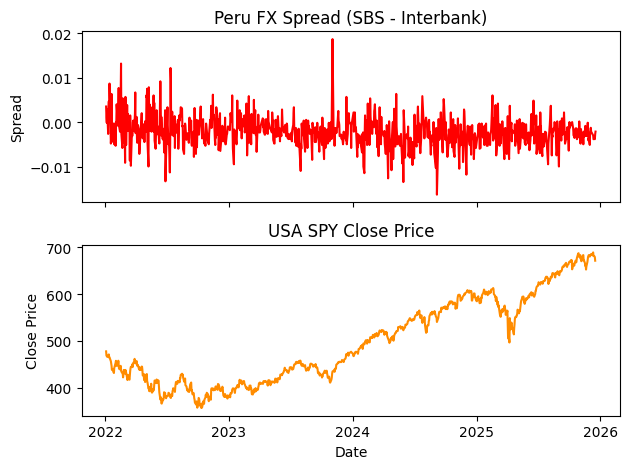

In [34]:
import matplotlib.dates as mdates

### 3. Use plt.subplots(nrows=2, ncols=1, sharex=True).
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
### 4. Add titles, axis labels, and use fig.tight_layout().
axes[0].plot(peru_fx_spread, color='red')
axes[0].set_title('Peru FX Spread (SBS - Interbank)') ## Tittle
axes[0].set_ylabel('Spread') ## Label axis Y

axes[1].plot(usa_spy_close, color='darkorange')
axes[1].set_title('USA SPY Close Price')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Close Price')

# 4.1 Format x-axis to show only years
major_locator = mdates.YearLocator() # Locator for years
major_formatter = mdates.DateFormatter('%Y') # Formatter for year (e.g., 2022)

axes[1].xaxis.set_major_locator(major_locator)
axes[1].xaxis.set_major_formatter(major_formatter)

fig.tight_layout()
plt.show()

### Exercise 3.2 — Annotations (mark a key event on a series)
Annotate the largest absolute daily SPY return.

**Tasks**
1. Find the date with the largest `abs(ret)` for SPY.
2. Plot SPY returns over time.
3. Add an annotation at the extreme point (arrow + text).

In [35]:

### 1. Find the date with the largest abs(ret) for SPY.
usa_spy_ret = usa[usa['ticker'] == 'SPY'][['date', 'ret']].copy()
usa_spy_ret = usa_spy_ret.rename(columns={'ret': 'SPY_returns'})
usa_spy_ret = usa_spy_ret.dropna(subset=['SPY_returns']).reset_index(drop=True)
usa_spy_ret['abs_ret'] = abs(usa_spy_ret['SPY_returns'])
print(usa_spy_ret.head())
max_abs_ret_date = usa_spy_ret.loc[usa_spy_ret['abs_ret'].idxmax(), ['abs_ret', 'date']]
print(f'___'*20)
print(max_abs_ret_date)
date_max_abs_ret = max_abs_ret_date['date']
abs_ret_max_abs_ret = max_abs_ret_date['abs_ret']
print(f'The date with the largest abs return was: {date_max_abs_ret} with {abs_ret_max_abs_ret*100:.2f}% return )')



Price       date  SPY_returns   abs_ret
0     2022-01-04    -0.000335  0.000335
1     2022-01-05    -0.019202  0.019202
2     2022-01-06    -0.000939  0.000939
3     2022-01-07    -0.003954  0.003954
4     2022-01-10    -0.001244  0.001244
____________________________________________________________
Price
abs_ret               0.105019
date       2025-04-09 00:00:00
Name: 818, dtype: object
The date with the largest abs return was: 2025-04-09 00:00:00 with 10.50% return )


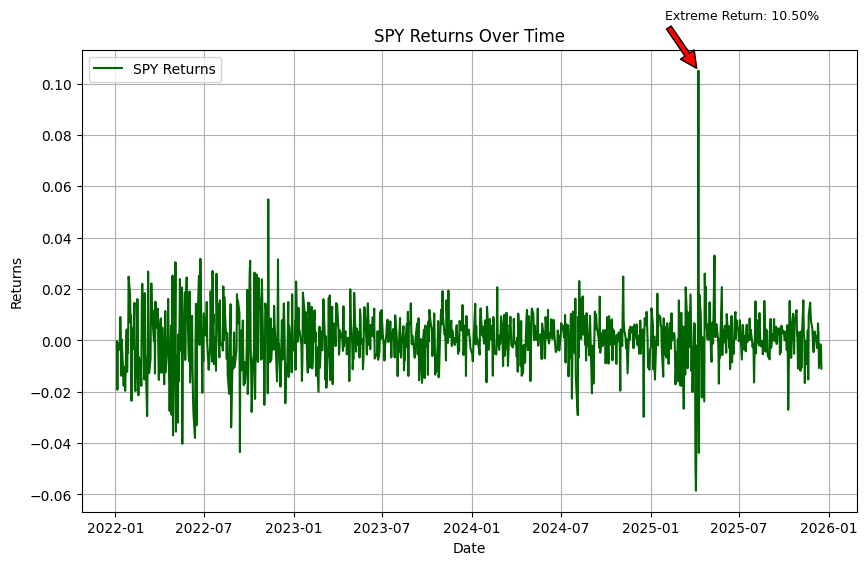

In [36]:
### 2. Plot SPY returns over time.
plt.figure(figsize=(10, 6))
plt.plot(usa_spy_ret['date'], usa_spy_ret['SPY_returns'], label='SPY Returns', color='darkgreen')
plt.title('SPY Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.legend()

### 3. Add an annotation at the extreme point (arrow + text).
max_date = max_abs_ret_date['date']
max_return = usa_spy_ret.loc[usa_spy_ret['date'] == max_date, 'SPY_returns'].iloc[0]

plt.annotate(
    f'Extreme Return: {max_return:.2%}',
    xy=(max_date, max_return),
    xytext=(max_date + pd.Timedelta(days=90), max_return + 0.02), # Offset text for readability
    arrowprops=dict(facecolor='red', shrink=0.05),
    ha='center',
    fontsize=9
)
plt.show()

### Exercise 3.3 — Saving the figure
Save one of your figures to disk.

**Tasks**
1. Create a folder `figures/` if it does not exist.
2. Save the subplot figure as `figures/lecture4II_fx_spy.png` with dpi=150.
3. Confirm the file exists.

In [39]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
### 1. Create a folder figures/ if it does not exist.
figures_folder = Path("figures/")
figures_folder.mkdir(parents=True, exist_ok=True)

### 2. Save the subplot figure as figures/lecture4II_fx_spy.png with dpi=150.
fig.savefig(figures_folder / "lecture4II_fx_spy_group_3.png", dpi=150)

### 3. Confirm the file exists.
print(figures_folder / "lecture4II_fx_spy_group_3.png")


## 4) Statistics
### Exercise 4.1 — Summary statistics table (returns)
Build a clean table of return moments.

**Tasks**
1. Create a wide daily returns table for SPY, TLT, GLD.
2. Compute: mean, std, skewness, kurtosis.
3. Present results as a DataFrame with tickers as rows.

In [ ]:
usa

In [ ]:
### 1.Create a wide daily returns table for SPY, TLT, GLD.
usa_ret = usa.pivot(index='date', columns='ticker', values='ret')
print(usa_ret)

### 2. Compute: mean, std, skewness, kurtosis.
summary_stats = usa_ret.agg(['mean', 'std', 'skew', 'kurtosis']).T

### 3. Present results as a DataFrame with tickers as rows.
summary_stats_df = pd.DataFrame(summary_stats)
print('\n\n')
print('Summary statistics table (returns):')
print(summary_stats_df)


### Exercise 4.2 —
Run a simple regression of GLD returns on SPY returns:

\[
GLD_t = \alpha + \beta\,SPY_t + \varepsilon_t
\]

**Tasks**
1. Build aligned return vectors (drop missing).
2. Compute \alpha and \beta using the closed-form OLS formulas.
3. Plot the scatter and fitted line.
4. Interpret \beta in 2–3 sentences.

In [ ]:
### 1. Build aligned return veectors (drop missing)
gld_spy_ret = usa_ret[['SPY', 'GLD']] ### Filter by ticker = SPY, GLD
print(gld_spy_ret.head(4))
gld_spy_ret = gld_spy_ret.dropna()
print(gld_spy_ret.head(4))

vector_spy = np.array(gld_spy_ret['SPY']) ### Transform to np.array (vector) object
vector_gld = np.array(gld_spy_ret['GLD'])
print(vector_spy[0:10])
print(vector_gld[0:10])

In [ ]:
### 2. Compute \alpha and \beta using the closed-form OLS formulas.
beta = np.cov(vector_spy, vector_gld)[0, 1] / np.var(vector_spy)
alpha = np.mean(vector_gld) - beta * np.mean(vector_spy)
print(f'Alpha: {alpha}')
print(f'Beta: {beta}')


In [ ]:
### 3. Plot the scatter and fitted line.
plt.scatter(vector_spy, vector_gld, label='Scatter Plot', color='blue', alpha=0.5)
plt.plot(vector_spy, alpha + beta * vector_spy, color='red', label='Regression Line') ### the line is the formula Lineal Regression
plt.xlabel('SPY Returns')
plt.ylabel('GLD Returns')
plt.title('Scatter Plot and Regression Line')
plt.legend()

According to the closed-form bivariate linear regression formula, assuming the classical assumptions are met, a positive movement of +1 point in SPY (ETF tracking the S&P 500) would result in a +0.1019 point movement in GLD (gold). Furthermore, alpha values close to zero in models like CAPM would indicate no additional returns above the Equity Risk Premium (represented by the S&P 500).

## 5) Risk and Uncertainty

### Exercise 5.1 — Historical VaR (95%) for a 60/40 portfolio
Portfolio:
- 60% SPY
- 40% TLT

**Tasks**
1. Create a wide returns table for SPY and TLT.
2. Compute portfolio daily returns.
3. Compute 1-day 95% Historical VaR (the 5th percentile of returns).
4. Compute 1-day 95% CVaR (average return below the 5th percentile).

In [ ]:
### 1.Create a wide returns table for SPY and TLT.
usa_ret = usa.pivot(index='date', columns='ticker', values='ret').sort_index() ### Llevamos el DF de formato largo a ancho, además es importante que esté ordenado el df
print(usa_ret)

### 2. Compute portfolio daily returns.
usa_ret['portfolio'] = 0.6 * usa_ret['SPY'] + 0.4 * usa_ret['TLT'] ### Creamos una columna que representará el portafolio
print(usa_ret)
print(usa_ret.isnull().sum())
usa_ret = usa_ret.dropna() ### Nosa aseguramos que no tenga valores perdidos
###3. Compute 1-day 95% Historical VaR (the 5th percentile of returns)

## Historical VaR 95%
var_95_return = usa_ret["portfolio"].quantile(0.05)
print("Historical VaR 95% (5th percentile return):", var_95_return) ### El VaR es el 5% de la serie de retornos


## CVaR 95%
threshold = var_95_return
cvar_95_return = usa_ret.loc[usa_ret["portfolio"] <= threshold, "portfolio"].mean() ### El CVaR es el esperado sobre los valores debajo del percentil 5%, es una prueba más ácida.

print("Historical CVaR 95% (avg return below 5th pct):", cvar_95_return)

Comentario: Se observa que el portafolio en su percentil de pérdida historico del 5%  es de: -1.37% y en su prueba más ácida con el CVaR es de : -1.86%

## 6) References

- BCRPData API (CSV endpoint): BCRP statistical series API for downloading time series
- BCRP series catalog: codes for FX (interbank/SBS) and commodity reference prices
- yfinance: Python wrapper to access historical market data from Yahoo Finance